In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sns

In [2]:
train_ds, val_ds = keras.utils.text_dataset_from_directory(
    './aclImdb/train/',
    validation_split= 0.2,
    subset='both',
    seed=225,
)

test_ds = keras.utils.text_dataset_from_directory(
    './aclImdb/test/',
    seed=225,
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [3]:
max_tokens = 25000
max_length = 900

text_vectorizer = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_length,
)

text_only_train_ds = train_ds.map(lambda x, y: x)

text_vectorizer.adapt(text_only_train_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [4]:
int_train_ds = train_ds.map(lambda x, y: (text_vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
int_val_ds = val_ds.map(lambda x, y: (text_vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
int_test_ds = test_ds.map(lambda x, y: (text_vectorizer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [5]:
inputs = keras.Input(shape=(None,), dtype='int64')

embeded = keras.layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)

x = keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True))(embeded)
x = keras.layers.Bidirectional(keras.layers.LSTM(32))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         6400000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         73984     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65    

In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/2-layer_bilstm.h5', save_weights_only=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5)
]

history = model.fit(int_train_ds, validation_data=int_val_ds, batch_size=128, epochs=10, callbacks=callbacks)


Epoch 1/10


625/625 [==============================] - 167s 237ms/step - loss: 0.4262 - accuracy: 0.7985 - val_loss: 0.3049 - val_accuracy: 0.8714 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 113s 181ms/step - loss: 0.2571 - accuracy: 0.8991 - val_loss: 0.2782 - val_accuracy: 0.8872 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 105s 168ms/step - loss: 0.1864 - accuracy: 0.9308 - val_loss: 0.4681 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 100s 160ms/step - loss: 0.1279 - accuracy: 0.9540 - val_loss: 0.3685 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 92s 147ms/step - loss: 0.0864 - accuracy: 0.9708 - val_loss: 0.4527 - val_accuracy: 0.8838 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 95s 152ms/step - loss: 0.0591 - accuracy: 0.9807 - val_loss: 0.5148 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 94s 1

<AxesSubplot: >

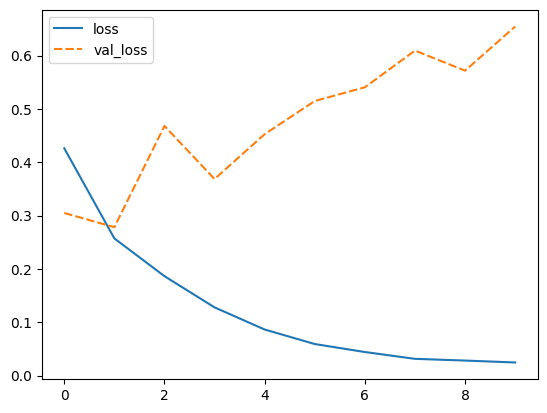

In [7]:
sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})

<AxesSubplot: >

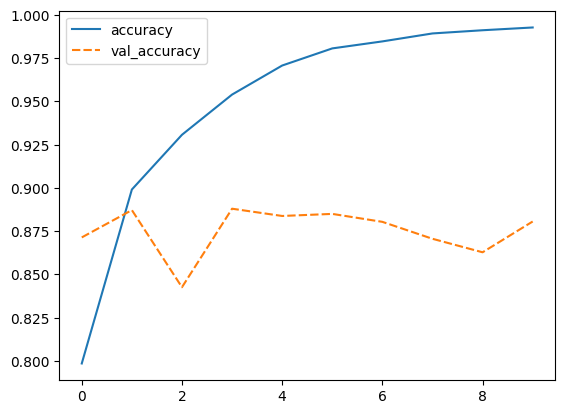

In [8]:
sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})


In [11]:
model.load_weights('checkpoints/2-layer_bilstm.h5')

In [15]:
model.evaluate(int_test_ds)

782/782 [==============================] - 49s 62ms/step - loss: 0.7451 - accuracy: 0.8585


[0.7451250553131104, 0.858519971370697]